## Sztuczna sieć neuronowa do klasyfikacji ceny mieszkań
Jakub Kowalczyk, Świderek Kinga

Załóżmy, że chcemy kupić mieszkanie. Do dyspozycji mamy 100 000 dolarów, możemy też wziąć kredyt na kolejne 250 tysięcy, co da nam w sumie budżet w wysokości 350 000 dolarów. Stwórzmy model który pomoże nam przewidzieć, czy mieszkanie o pewnych, zadanych parametrach, możemy kupić za własne pieniądze (cheap), z kredytem (average), czy jest poza naszym zasięgiem (expensive).

W oparciu o dostępne atrybuty zbudujemy model, który pomoże oszacować, czy dana nieruchomość należy do klasy cheap, average czy expensive. Do dyspozycji są dostępne dane treningowe (train_data.csv) z oryginalnymi cenami nieruchomości (SalePrice), oraz zbiór testowy (test_data.csv).

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from IPython.display import display
from tabulate import tabulate

In [144]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Wczytanie i analiza danych

In [145]:
# Load dataframes
train_df = pd.read_csv("train_data.csv")
eval_df = pd.read_csv("test_data.csv")

own_budget = 100000
total_budget = 350000
train_df['PriceClass'] = pd.cut(train_df['SalePrice'], bins=[-np.inf, own_budget, total_budget, np.inf], labels=[0, 1, 2])

# All features counts
tables = []

for column in train_df.columns[1:]:
    table = pd.DataFrame(train_df[column].value_counts()).reset_index()
    table.columns = [column, 'Count']
    tables.append(table)

for table in tables:
    print(f"\nData Type: {train_df[table.columns[0]].dtype}")
    print(tabulate(table, headers='keys', tablefmt='pipe'))


Data Type: int64
|    |   YearBuilt |   Count |
|---:|------------:|--------:|
|  0 |        2007 |     881 |
|  1 |        2005 |     512 |
|  2 |        1993 |     478 |
|  3 |        2006 |     471 |
|  4 |        1992 |     322 |
|  5 |        2013 |     307 |
|  6 |        2014 |     271 |
|  7 |        1986 |     244 |
|  8 |        2008 |     198 |
|  9 |        2009 |     164 |
| 10 |        2015 |      89 |
| 11 |        1997 |      77 |
| 12 |        1978 |      51 |
| 13 |        1985 |      47 |
| 14 |        2003 |       8 |
| 15 |        1980 |       4 |

Data Type: int64
|    |   Size(sqf) |   Count |
|---:|------------:|--------:|
|  0 |         914 |     683 |
|  1 |         644 |     491 |
|  2 |         910 |     381 |
|  3 |         868 |     209 |
|  4 |         572 |     198 |
|  5 |         903 |     133 |
|  6 |         743 |     107 |
|  7 |        1643 |      86 |
|  8 |        1387 |      86 |
|  9 |         576 |      84 |
| 10 |         355 |      80 |
| 1

### Przygotowanie danych (encoding i skalowanie)

In [146]:
# Drop label
train_df.drop(columns=['SalePrice'], axis=1, inplace=True)

# Convert categorical variables to one-hot encoding
categorical_cols = ['HallwayType', 'SubwayStation', 'HeatingType', 'AptManageType', 'TimeToBusStop', 'TimeToSubway']
train_df = pd.get_dummies(train_df, columns=categorical_cols)
eval_df = pd.get_dummies(eval_df, columns=categorical_cols)

numerical_cols = ['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)',
                  'N_manager', 'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
categorical_cols_encoded = [col for col in train_df.columns if col not in numerical_cols]
categorical_cols_encoded.remove('PriceClass')

# Normalize numerical features values
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
eval_df[numerical_cols] = scaler.fit_transform(eval_df[numerical_cols])

In [147]:
train_df.head()

,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),...,AptManageType_management_in_trust,AptManageType_self_management,TimeToBusStop_0~5min,TimeToBusStop_10min~15min,TimeToBusStop_5min~10min,TimeToSubway_0-5min,TimeToSubway_10min~15min,TimeToSubway_15min~20min,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby
0,0.344797,-0.379605,-1.186567,-0.379655,-0.952778,-1.027793,-1.432820,-0.351614,-1.120745,-0.423026,...,1,0,0,0,1,0,1,0,0,0
1,-2.051157,-0.969979,-0.526972,-0.523554,-1.217399,-1.337950,-1.173621,-1.204839,0.621197,-1.552482,...,0,1,1,0,0,0,0,0,1,0
2,-2.051157,-0.969979,-0.790810,-0.523554,-1.217399,-1.337950,-1.173621,-1.204839,0.621197,-1.552482,...,0,1,1,0,0,0,0,0,1,0
3,0.344797,2.850549,-0.526972,0.260925,-0.090309,-0.407477,-0.007228,-0.351614,-1.991717,-0.874808,...,1,0,1,0,0,1,0,0,0,0
4,-1.252506,-0.821735,-1.318486,-0.235757,-1.210049,-0.717635,-0.396026,-1.204839,-0.249774,0.706431,...,0,1,0,0,1,0,0,1,0,0


In [148]:
train_df.dtypes

YearBuilt                               float64
Size(sqf)                               float64
Floor                                   float64
N_Parkinglot(Ground)                    float64
N_Parkinglot(Basement)                  float64
N_manager                               float64
N_elevators                             float64
N_FacilitiesInApt                       float64
N_FacilitiesNearBy(Total)               float64
N_SchoolNearBy(Total)                   float64
PriceClass                             category
HallwayType_corridor                      uint8
HallwayType_mixed                         uint8
HallwayType_terraced                      uint8
SubwayStation_Bangoge                     uint8
SubwayStation_Banwoldang                  uint8
SubwayStation_Chil-sung-market            uint8
SubwayStation_Daegu                       uint8
SubwayStation_Kyungbuk_uni_hospital       uint8
SubwayStation_Myung-duk                   uint8
SubwayStation_Sin-nam                   

### Dataset i dataloadery

In [149]:
class HousingPriceDataset(Dataset):
    def __init__(self, data, is_eval=False):
        super().__init__()
        if not is_eval:
            self.y = torch.tensor(data['PriceClass'].values, dtype=torch.float32)
            x_data = data.drop(columns=['PriceClass'])
        else:
            self.y = torch.from_numpy(pd.Series([0]*len(data)).values)
            x_data = data

        self.categorical_x = torch.tensor(x_data[categorical_cols_encoded].values, dtype=torch.long)
        self.numerical_x = torch.tensor(x_data[numerical_cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.categorical_x[idx], self.numerical_x[idx], self.y[idx]

train_data, test_data = train_test_split(train_df, train_size=0.8, random_state=42)
train_dataset = HousingPriceDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = HousingPriceDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### Definicja modelu

In [150]:
class HousingPriceNet(nn.Module):
    def __init__(self, num_categorical_features, num_numerical_features, hidden_dim1=128, hidden_dim2=128, hidden_dim3=64):
        super(HousingPriceNet, self).__init__()

        # embedding layers for categorical features
        self.embeddings = nn.ModuleList([nn.Embedding(num_embeddings=feature_dim, embedding_dim=embedding_dim)
                                         for feature_dim, embedding_dim in num_categorical_features])

        # input dimensions for numerical features
        input_dim = len(num_numerical_features)

        total_embedding_dim = sum([embedding_dim for _, embedding_dim in num_categorical_features])
        total_input_dim = total_embedding_dim + input_dim

        self.input = nn.Linear(total_input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.hidden_1 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.hidden_2 = nn.Linear(hidden_dim2, hidden_dim3)
        self.bn3 = nn.BatchNorm1d(hidden_dim3)
        self.output = nn.Linear(hidden_dim3, 3)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.08)

    def forward(self, categorical_x, numerical_x):
        embedded_x = [embedding_layer(categorical_x[:, i]) for i, embedding_layer in enumerate(self.embeddings)]
        embedded_x = torch.cat(embedded_x, dim=1)

        # concatenate embedded features with numerical features
        x = torch.cat([embedded_x, numerical_x], dim=1)

        x = self.input(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.hidden_1(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.hidden_2(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.output(x)
        return x


def train(model, train_loader, test_loader, criterion, optimizer, num_epochs=400):
    train_losses = []
    train_accuracies = []
    train_class_accuracies = {0: [], 1: [], 2: []}

    test_losses = []
    test_accuracies = []
    test_class_accuracies = {0: [], 1: [], 2: []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        class_correct_train = [0, 0, 0]
        class_total_train = [0, 0, 0]

        for categorical_x, numerical_x, labels in train_loader:
            categorical_x, numerical_x, labels = categorical_x.to(device), numerical_x.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(categorical_x, numerical_x)
            loss = criterion(outputs, labels.long())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # training accuracy for each class
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            for i in range(3):
                class_correct_train[i] += ((predicted_train == labels) & (labels == i)).sum().item()
                class_total_train[i] += (labels == i).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        for i in range(3):
            class_accuracy_train = class_correct_train[i] / class_total_train[i] if class_total_train[i] > 0 else 0
            train_class_accuracies[i].append(class_accuracy_train)

        # Evaluation
        model.eval()
        correct_test = 0
        total_test = 0
        test_loss = 0.0
        class_correct_test = [0, 0, 0]
        class_total_test = [0, 0, 0]

        with torch.no_grad():
            for categorical_x, numerical_x, labels in test_loader:
                categorical_x, numerical_x, labels = categorical_x.to(device), numerical_x.to(device), labels.to(device)
                outputs = model(categorical_x, numerical_x)
                _, predicted_test = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()
                test_loss += criterion(outputs, labels.long()).item()

                # accuracy for each class on test set
                for i in range(3):
                    class_correct_test[i] += ((predicted_test == labels) & (labels == i)).sum().item()
                    class_total_test[i] += (labels == i).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)

        for i in range(3):
            class_accuracy_test = class_correct_test[i] / class_total_test[i] if class_total_test[i] > 0 else 0
            test_class_accuracies[i].append(class_accuracy_test)

        if (epoch+1) % 50 == 0:
          print(f"Train: Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy:.3f}")
          print(f"Train: Epoch {epoch+1}/{num_epochs}, Class 0 acc: {train_class_accuracies[0][-1]:.3f}, Class 1 acc: {train_class_accuracies[1][-1]:.3f}, Class 2 acc: {train_class_accuracies[2][-1]:.3f}")
          print(f"Test: Epoch {epoch+1}/{num_epochs}, Loss: {test_loss/len(test_loader):.3f}, Accuracy: {test_accuracy:.3f}")
          print(f"Test: Epoch {epoch+1}/{num_epochs}, Class 0 acc: {test_class_accuracies[0][-1]:.3f}, Class 1 acc: {test_class_accuracies[1][-1]:.3f}, Class 2 acc: {test_class_accuracies[2][-1]:.3f}")

    return train_losses, train_accuracies, train_class_accuracies, test_losses, test_accuracies, test_class_accuracies


### Trenowanie modelu

In [151]:
num_categorical_features = [(len(train_data[col].unique()), len(train_data[col].unique())) for col in categorical_cols_encoded]
num_numerical_features = [(1,)] * len(numerical_cols)
num_epochs = 500
model = HousingPriceNet(num_categorical_features, num_numerical_features).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(train_data['PriceClass']), y=train_data['PriceClass'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print(f"Class weights {class_weights_tensor}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
train_losses, train_accuracies, train_class_accuracies, test_losses, test_accuracies, test_class_accuracies = train(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Class weights tensor([2.5049, 0.4586, 2.3802], device='cuda:0')
Train: Epoch 50/500, Loss: 0.294, Accuracy: 0.811
Train: Epoch 50/500, Class 0 acc: 0.982, Class 1 acc: 0.758, Class 2 acc: 0.920
Test: Epoch 50/500, Loss: 0.284, Accuracy: 0.792
Test: Epoch 50/500, Class 0 acc: 1.000, Class 1 acc: 0.721, Class 2 acc: 0.944
Train: Epoch 100/500, Loss: 0.279, Accuracy: 0.808
Train: Epoch 100/500, Class 0 acc: 0.986, Class 1 acc: 0.747, Class 2 acc: 0.950
Test: Epoch 100/500, Loss: 0.271, Accuracy: 0.799
Test: Epoch 100/500, Class 0 acc: 1.000, Class 1 acc: 0.732, Class 2 acc: 0.935
Train: Epoch 150/500, Loss: 0.270, Accuracy: 0.806
Train: Epoch 150/500, Class 0 acc: 0.989, Class 1 acc: 0.746, Class 2 acc: 0.939
Test: Epoch 150/500, Loss: 0.270, Accuracy: 0.795
Test: Epoch 150/500, Class 0 acc: 1.000, Class 1 acc: 0.727, Class 2 acc: 0.935
Train: Epoch 200/500, Loss: 0.266, Accuracy: 0.805
Train: Epoch 200/500, Class 0 acc: 0.993, Class 1 acc: 0.746, Class 2 acc: 0.933
Test: Epoch 200/500, L

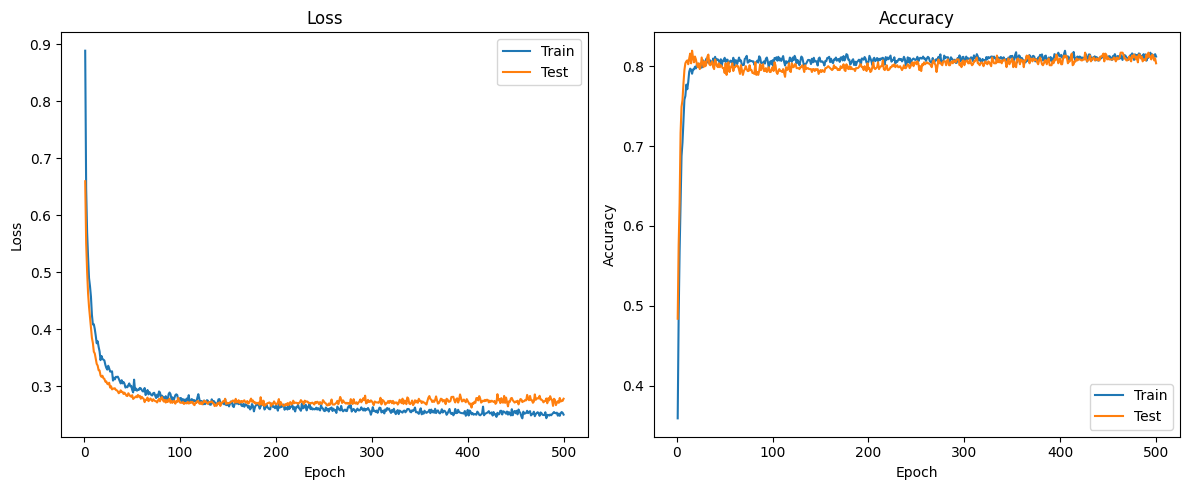

In [152]:
epochs = np.arange(1, num_epochs + 1)

# Loss plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, test_losses, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train')
plt.plot(epochs, test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

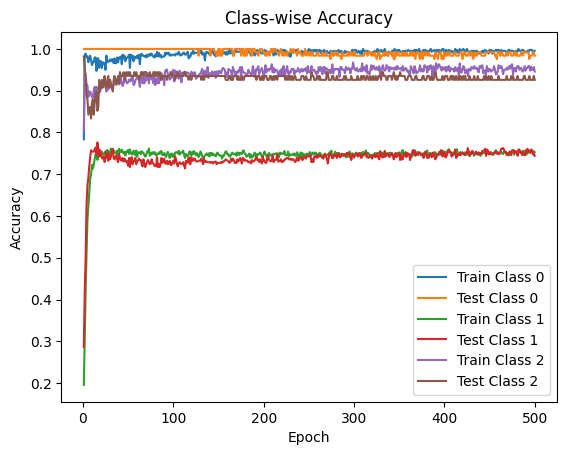

In [153]:
# Class-wise accuracy plot
for i in range(3):
    plt.plot(epochs, train_class_accuracies[i], label=f'Train Class {i}')
    plt.plot(epochs, test_class_accuracies[i], label=f'Test Class {i}')

plt.title('Class-wise Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Predykcja

In [154]:
def predict(model, data_loader):
    predictions = []

    with torch.no_grad():
        for categorical_x, numerical_x, _ in data_loader:
            categorical_x, numerical_x = categorical_x.to(device), numerical_x.to(device)

            outputs = model(categorical_x, numerical_x)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions


In [155]:
evaluation_dataset = HousingPriceDataset(eval_df, is_eval=True)
evaluation_loader = DataLoader(evaluation_dataset, batch_size=64, shuffle=False)
predicted_values_eval = predict(model, evaluation_loader)
pd.DataFrame(predicted_values_eval).to_csv("poniedzialek_Kowalczyk_Swiderek.csv", index=False, header=None)